Bidirectional HR Matching Hub using Embedding-Based Similarity for Scalable Talent Matching

Job Description EDA notebook, cleaning, and report
source: https://www.kaggle.com/datasets/arshkon/linkedin-job-postings (LinkedIn Job Postings (2023 - 2024)

In [1]:
#import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter

Create the directories to eaier organize data and output

In [2]:
#create necessary directories to store data and results
Path("data/raw").mkdir(parents=True, exist_ok=True)
Path("data/processed").mkdir(parents=True, exist_ok=True)
Path("notebooks").mkdir(parents=True, exist_ok=True)
Path("figures").mkdir(parents=True, exist_ok=True)
print("Directories created successfully")

Directories created successfully


Data Exploration

See the main datastructure
- jobs_df = the main file containg major columns like 'job_id', 'company_id', 'title', 'description', 'company_name',
    'location', 'formatted_work_type', 'formatted_experience_level',
    'original_listed_time', 'remote_allowed', 'normalized_salary'

In [3]:
print("\n" + "="*50)
print("Download data from LinkedIn Jobs 2023-2024 dataset on Kaggle:")
print("="*50)

#Download main file from Kaggle
try:
    #Load dataset
    jobs_df = pd.read_csv('data/raw/postings.csv')
    print(f"Sucessfully Download Dataset: {len(jobs_df)} jobs")
    
    #Data structure overview
    print("\nData Structure:")
    print(jobs_df.info())
    
    #Data oreview
    print("\nData Preview of first 3 raws:")
    print(jobs_df.head(3))
    
    #Column names
    print("\nColumn List:")
    print(jobs_df.columns.tolist())
    
except FileNotFoundError:
    print("File is not found")
except Exception as e:
    print(f"An error occurred: {e}")


Download data from LinkedIn Jobs 2023-2024 dataset on Kaggle:
Sucessfully Download Dataset: 123849 jobs

Data Structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123849 entries, 0 to 123848
Data columns (total 31 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   job_id                      123849 non-null  int64  
 1   company_name                122130 non-null  object 
 2   title                       123849 non-null  object 
 3   description                 123842 non-null  object 
 4   max_salary                  29793 non-null   float64
 5   pay_period                  36073 non-null   object 
 6   location                    123849 non-null  object 
 7   company_id                  122132 non-null  float64
 8   views                       122160 non-null  float64
 9   med_salary                  6280 non-null    float64
 10  min_salary                  29793 non-null   float64
 11  formatte

See the additional dataset structure because there's additional information needed to be merge with the main dataset to make data cleaning and EDA that is also relevant to master's plan
- job_skill = job id with skills abreviation which one job can contains more than one skills
- skills = skill abreviation with skill name
- job_industries = job id with job industry id which one job can contains more than one industries
- industries = industry id and industry name

Theres also the company industries on file zip ready to use if necessary but from my justification we are matching candidate with perfect jobs (title) and company's role with perfect candidate, so i decided not to include the description and industries of company to this notebook
- by having foundation of job industries and skills might be beneficial during extracting from jobdescriptions process to hidden required hard or soft skills 

In [4]:
print("\n" + "="*50)
print("Download additional data from zip files:")
print("="*50)
job_skills = pd.read_csv("data/raw/job_skills.csv")
skills = pd.read_csv("data/raw/skills.csv")
job_industries = pd.read_csv("data/raw/job_industries.csv")
industries = pd.read_csv("data/raw/industries.csv")

print("\n" + "="*50)
print("Job and Skills:")
print("="*50)

#Data structure overview
print("\nData Structure of Jobs and Skills:")
print(job_skills.info())
    
#Data oreview
print("\nData Preview of first 3 raws:")
print(job_skills.head(3))
    
#Column names
print("\nColumn List:")
print(job_skills.columns.tolist())

print("\n" + "="*50)
print("Job and Industries:")
print("="*50)

#Data structure overview
print("\nData Structure of Jobs and Industries:")
print(job_industries.info())
    
#Data oreview
print("\nData Preview of first 3 raws:")
print(job_industries.head(3))
    
#Column names
print("\nColumn List:")
print(job_industries.columns.tolist())


Download additional data from zip files:

Job and Skills:

Data Structure of Jobs and Skills:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213768 entries, 0 to 213767
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   job_id     213768 non-null  int64 
 1   skill_abr  213768 non-null  object
dtypes: int64(1), object(1)
memory usage: 3.3+ MB
None

Data Preview of first 3 raws:
       job_id skill_abr
0  3884428798      MRKT
1  3884428798        PR
2  3884428798       WRT

Column List:
['job_id', 'skill_abr']

Job and Industries:

Data Structure of Jobs and Industries:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164808 entries, 0 to 164807
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype
---  ------       --------------   -----
 0   job_id       164808 non-null  int64
 1   industry_id  164808 non-null  int64
dtypes: int64(2)
memory usage: 2.5 MB
None

Data Preview of first 3 raws:
      

Select the core job columns as per I explain previously and call this main dataframe as 'jobs_clean'

In [5]:
CORE_JOB_COL = [
    'job_id', 'company_id', 'title', 'description', 'company_name',
    'location', 'formatted_work_type', 'formatted_experience_level',
    'original_listed_time', 'remote_allowed', 'normalized_salary'
]

jobs_clean = jobs_df[CORE_JOB_COL].copy()

- Merge (1) Job id with industry name

In [6]:
job_ind_full = job_industries.merge(
    industries[['industry_id', 'industry_name']],
    on='industry_id',
    how='left'
)

#Using groupby (1) on this code box because one job id can contains more than one indutries
industries_per_job = (
    job_ind_full.groupby('job_id')['industry_name']
    .apply(list)
    .reset_index()
)
industries_per_job.head()

#Merge it to jobs_clean (1) which now becoming our main dataframe
jobs_clean = jobs_clean.merge(industries_per_job, on='job_id', how='left')


- Merge (2) skill abbreviation on job with skill with skill name

In [7]:
job_skill_full = job_skills.merge(
    skills[['skill_abr', 'skill_name']],
    on='skill_abr',
    how='left'
)

#Using groupby (2) on this code box because one job id can contains more than one skills
skills_per_job = (
    job_skill_full
    .groupby('job_id')['skill_name']
    .apply(list)
    .reset_index()
    .rename(columns={'skill_name': 'skill_list'})
)

#Merge it to jobs_clean (2) which now becoming our main dataframe
jobs_clean = jobs_clean.merge(skills_per_job, on='job_id', how='left')

In [8]:
#check dataframe info
print(jobs_clean.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123849 entries, 0 to 123848
Data columns (total 13 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   job_id                      123849 non-null  int64  
 1   company_id                  122132 non-null  float64
 2   title                       123849 non-null  object 
 3   description                 123842 non-null  object 
 4   company_name                122130 non-null  object 
 5   location                    123849 non-null  object 
 6   formatted_work_type         123849 non-null  object 
 7   formatted_experience_level  94440 non-null   object 
 8   original_listed_time        123849 non-null  float64
 9   remote_allowed              15246 non-null   float64
 10  normalized_salary           36073 non-null   float64
 11  industry_name               122413 non-null  object 
 12  skill_list                  122096 non-null  object 
dtypes: float64(4),

Missing Value Checking


2. Missing Data:
                    Column  Missing  Percentage
               closed_time   122776       99.13
               skills_desc   121410       98.03
                med_salary   117569       94.93
            remote_allowed   108603       87.69
                   applies   100529       81.17
                min_salary    94056       75.94
                max_salary    94056       75.94
                pay_period    87776       70.87
         compensation_type    87776       70.87
         normalized_salary    87776       70.87
                  currency    87776       70.87
            posting_domain    39968       32.27
           application_url    36665       29.60
formatted_experience_level    29409       23.75
                      fips    27415       22.14
                  zip_code    20872       16.85
              company_name     1719        1.39
                company_id     1717        1.39
                     views     1689        1.36
               descrip

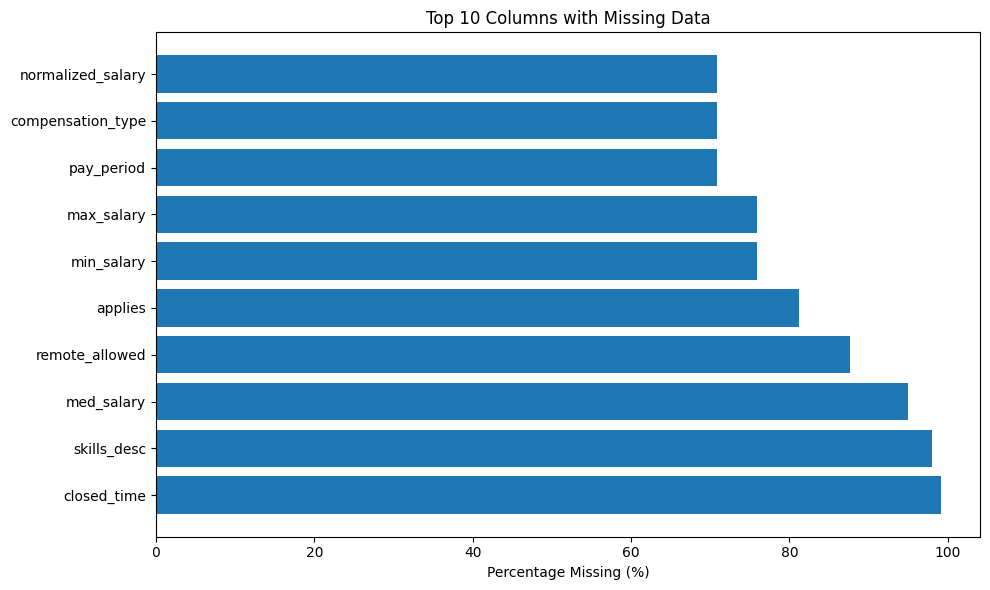

In [9]:
#missing values
print("\n2. Missing Data:")
missing = jobs_df.isnull().sum()
missing_pct = (missing / len(jobs_df) * 100).round(2)
missing_df = pd.DataFrame({
    'Column': missing.index,
    'Missing': missing.values,
    'Percentage': missing_pct.values
})
missing_df = missing_df[missing_df['Missing'] > 0].sort_values('Missing', ascending=False)

print(missing_df.to_string(index=False))

if len(missing_df) > 0:
    plt.figure(figsize=(10, 6))
    plt.barh(missing_df['Column'][:10], missing_df['Percentage'][:10])
    plt.xlabel('Percentage Missing (%)')
    plt.title('Top 10 Columns with Missing Data')
    plt.tight_layout()
    plt.savefig('figures/BC01missing_data_jobs.png', dpi=300, bbox_inches='tight')
    print("Saved plot: figures/BC01missing_data_jobs.png")

Missing Value Handling

In [10]:
print("\nHandle Missing Values:")
before = len(jobs_clean)

#Drop rows missing title or description which only few found
jobs_clean = jobs_clean.dropna(subset=['title', 'description'])
print(f"   Dropped missing title/description: {before - len(jobs_clean):,} rows")

#Fill missing company name with unknown
if 'company_name' in jobs_clean.columns:
    jobs_clean.loc[:, 'company_name'] = jobs_clean['company_name'].fillna('Unknown')

#Fill missing location with unknown
if 'location' in jobs_clean.columns:
    jobs_clean.loc[:, 'location'] = jobs_clean['location'].fillna('Unknown')

#Fill missing work type with unknown
if 'formatted_work_type' in jobs_clean.columns:
    jobs_clean.loc[:, 'formatted_work_type'] = jobs_clean['formatted_work_type'].fillna('unknown')

#Fill missing remote flag because 1 is ticked (yes) and NaN means not ticked (no) which is 0
if 'remote_allowed' in jobs_clean.columns:
    jobs_clean.loc[:, 'remote_allowed'] = jobs_clean['remote_allowed'].fillna('0')

#Fill missing formatted_experience_level
if 'formatted_experience_level' in jobs_clean.columns:
    jobs_clean.loc[:, 'formatted_experience_level'] = (
        jobs_clean['formatted_experience_level']
        .astype(str)
        .fillna('unknown')
    )

#Fill missing industry_name with Unknown
jobs_clean['industry_name'] = jobs_clean['industry_name'].fillna('Unknown')
#Fill missing skill_list with Unknown
jobs_clean['skill_list'] = jobs_clean['skill_list'].fillna('Unknown')
#Fill missing company_id with '00000'
jobs_clean['company_id'] = jobs_clean['company_id'].fillna('00000')

print("   Filled missing values for all applicable columns")



Handle Missing Values:
   Dropped missing title/description: 7 rows
   Filled missing values for all applicable columns


C:\Users\Jonas Pedesk\AppData\Local\Temp\ipykernel_20444\537652470.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['0' '0' '0' ... 1.0 1.0 '0']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  jobs_clean.loc[:, 'remote_allowed'] = jobs_clean['remote_allowed'].fillna('0')


Create internal ID for jobs and companies only for using in this semester project

In [11]:
#Create Internal Job ID and Company ID since the dataset contains linkedin id only, runing from 0001
#Assign internal job ID
jobs_clean['int_job_id'] = [f'JOB{i:06d}' for i in range(1, len(jobs_clean)+1)]
print("Create int_job_id as Internal Job ID")
print(jobs_clean[['title', 'int_job_id']].head(5))

#Assign internal company ID based on unique company names/ the unknown company count as one running from 0001
unique_companies = jobs_clean['company_name'].astype(str).unique()
company_id_map = {
    company: f"COM{idx+1:05d}" for idx, company in enumerate(unique_companies)
}
jobs_clean['int_company_id'] = jobs_clean['company_name'].map(company_id_map)
print("Create int_company_id as Internal Company ID")

print(jobs_clean[['company_name', 'int_company_id']].head(5))
print(f"Total Job ID: {len(jobs_clean['int_job_id']):,}")
print(f"Total unique companies (including Unknown): {len(unique_companies):,}")

Create int_job_id as Internal Job ID
                                               title int_job_id
0                              Marketing Coordinator  JOB000001
1                  Mental Health Therapist/Counselor  JOB000002
2                        Assitant Restaurant Manager  JOB000003
3  Senior Elder Law / Trusts and Estates Associat...  JOB000004
4                                 Service Technician  JOB000005
Create int_company_id as Internal Company ID
             company_name int_company_id
0   Corcoran Sawyer Smith       COM00001
1                 Unknown       COM00002
2  The National Exemplar        COM00003
3  Abrams Fensterman, LLP       COM00004
4                 Unknown       COM00002
Total Job ID: 123,842
Total unique companies (including Unknown): 24,423


Giving experience_level in numeric since the formatted_experience_level showing 6 levels of experiences

In [12]:
#Standardize string and delete unnecessary words
jobs_clean['formatted_experience_level'] = (
    jobs_clean['formatted_experience_level']
    .str.strip().str.lower()
    .str.replace(' level', '', regex=False)
    .str.replace('-', ' ')
)

#Define ordered mapping/ i define unknown as -1 to keep missing data saparated and avoid confusion with 0 years of experience
exp_map = {
    'nan': 0,
    'internship': 1,
    'entry': 2,
    'associate': 3,
    'mid senior': 4,
    'director': 5,
    'executive': 6,
    'unknown': -1
}

#Apply encoding
jobs_clean['experience_numeric'] = jobs_clean['formatted_experience_level'].map(exp_map)

Handle missing value of normalized_salary

In [13]:
#Do nothing - keep nan since the data missing of 70% normalized_salary // impute or drop later if nesessary

Checking data after cleaning process

In [14]:
jobs_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 123842 entries, 0 to 123848
Data columns (total 16 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   job_id                      123842 non-null  int64  
 1   company_id                  123842 non-null  object 
 2   title                       123842 non-null  object 
 3   description                 123842 non-null  object 
 4   company_name                123842 non-null  object 
 5   location                    123842 non-null  object 
 6   formatted_work_type         123842 non-null  object 
 7   formatted_experience_level  123842 non-null  object 
 8   original_listed_time        123842 non-null  float64
 9   remote_allowed              123842 non-null  object 
 10  normalized_salary           36072 non-null   float64
 11  industry_name               123842 non-null  object 
 12  skill_list                  123842 non-null  object 
 13  int_job_id         

In [15]:
jobs_clean.head(100)

,job_id,company_id,title,description,company_name,location,formatted_work_type,formatted_experience_level,original_listed_time,remote_allowed,normalized_salary,industry_name,skill_list,int_job_id,int_company_id,experience_numeric
0,921716,2774458.0,Marketing Coordinator,Job descriptionA leading real estate firm in N...,Corcoran Sawyer Smith,"Princeton, NJ",Full-time,nan,1.713398e+12,0,38480.0,[Real Estate],"[Marketing, Sales]",JOB000001,COM00001,0
1,1829192,00000,Mental Health Therapist/Counselor,"At Aspen Therapy and Wellness , we are committ...",Unknown,"Fort Collins, CO",Full-time,nan,1.712858e+12,0,83200.0,Unknown,[Health Care Provider],JOB000002,COM00002,0
2,10998357,64896719.0,Assitant Restaurant Manager,The National Exemplar is accepting application...,The National Exemplar,"Cincinnati, OH",Full-time,nan,1.713278e+12,0,55000.0,[Restaurants],"[Management, Manufacturing]",JOB000003,COM00003,0
3,23221523,766262.0,Senior Elder Law / Trusts and Estates Associat...,Senior Associate Attorney - Elder Law / Trusts...,"Abrams Fensterman, LLP","New Hyde Park, NY",Full-time,nan,1.712896e+12,0,157500.0,[Law Practice],[Other],JOB000004,COM00004,0
4,35982263,00000,Service Technician,Looking for HVAC service tech with experience ...,Unknown,"Burlington, IA",Full-time,nan,1.713452e+12,0,70000.0,[Facilities Services],[Information Technology],JOB000005,COM00002,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2920450495,80316732.0,Service Coordinator,"QualificationsExperience:Data Entry, 4 years (...",Grunwald Mechanical Contractors & Engineers,"Omaha, NE",Full-time,nan,1.712866e+12,0,65000.0,[Construction],Unknown,JOB000096,COM00065,0
96,2934066464,10104312.0,Fundraising Associate,The firm:Dynamic SRG is a boutique political c...,Dynamic SRG,New York City Metropolitan Area,Full-time,nan,1.712347e+12,0,NaN,[Government Relations Services],[Other],JOB000097,COM00066,0
97,2954591060,23674217.0,Social Media Coordinator,"Global Sculpted Streetwear fashion brand, Nake...",Naked Wardrobe,"Los Angeles, CA",Full-time,nan,1.713467e+12,0,55120.0,[Retail],"[Marketing, Sales]",JOB000098,COM00067,0
98,2957460032,10378739.0,Professional Window Cleaning Technician,"Executive Cleaning Services, Inc. is not a mai...","Executive Cleaning Services, Inc","Omaha, NE",Full-time,nan,1.712347e+12,0,67600.0,[Consumer Services],"[Management, Manufacturing]",JOB000099,COM00068,0


Variables explaination and reason behind choosing
1. job_id = job id from linkedin (still including it as when we check with the original data) 
2. company_id = company id from linkedin
3. title = title of the job
4. description = job description
5. company_name = name of the company
6. location = where the company located
7. formatted_work_type = type of working including 'Full-time', 'Internship', 'Contract', 'Part-time', 'Temporary', 'Volunteer', and 'Other'
8. formatted_experience_level = types of working experience level 'nan', 'entry', 'mid senior', 'associate', 'director','internship', 'executive'
9. original_listed_time = date and time posted in milliseconds but can convert to see the readable data using panda (pd.to_fatetime, unit='ms')
10. remote_allowed = 
11. normalized_salary = salary after normailzed, which normally it is anbually in USD, contains 36072 (approximately 70% missing values) // there's many suggestion to keep this NaN because imputing or fill with 0 or mean or med will create artificial bias. In case we use it to train model or predicting we can drop rows with missing value. but we can do it later.
12. industry_name = industry of job (by data mapping)
13. skill_list = skill of job (by data mapping)
14. int_job_id = internal job id
15. int_company_id = internal company id
16. formatted_experience_level = experience level converted into numeric


what this dataset does not contain and might have to use extraction from job descriptions during features engineering
1. Required Education
2. Detailed skills/ soft and hard skills
3. 20% of formatted_experience_level that i filled with unknown but there might be patterns on JD
4. Hidden Salary Given

In [16]:
jobs_clean['formatted_experience_level'].astype(str).unique()

array(['nan', 'entry', 'mid senior', 'associate', 'director',
       'internship', 'executive'], dtype=object)

Key Statistic&Visualization

In [17]:
exp_mean = jobs_clean['experience_numeric'].mean()
exp_median = jobs_clean['experience_numeric'].median()

print("Mean required experience:", exp_mean)
print("Median required experience:", exp_median)


Mean required experience: 2.3930572826666237
Median required experience: 2.0


In [18]:
salary_stats = jobs_clean['normalized_salary'].describe()
print("Salary Statistics:\n", salary_stats)

Salary Statistics:
 count    3.607200e+04
mean     2.053280e+05
std      5.097697e+06
min      0.000000e+00
25%      5.200000e+04
50%      8.150000e+04
75%      1.250000e+05
max      5.356000e+08
Name: normalized_salary, dtype: float64


In [19]:
remote_percent = jobs_clean['remote_allowed'].astype(int).mean() * 100
print(f"Remote work percentage: {remote_percent:.2f}%")

Remote work percentage: 12.31%


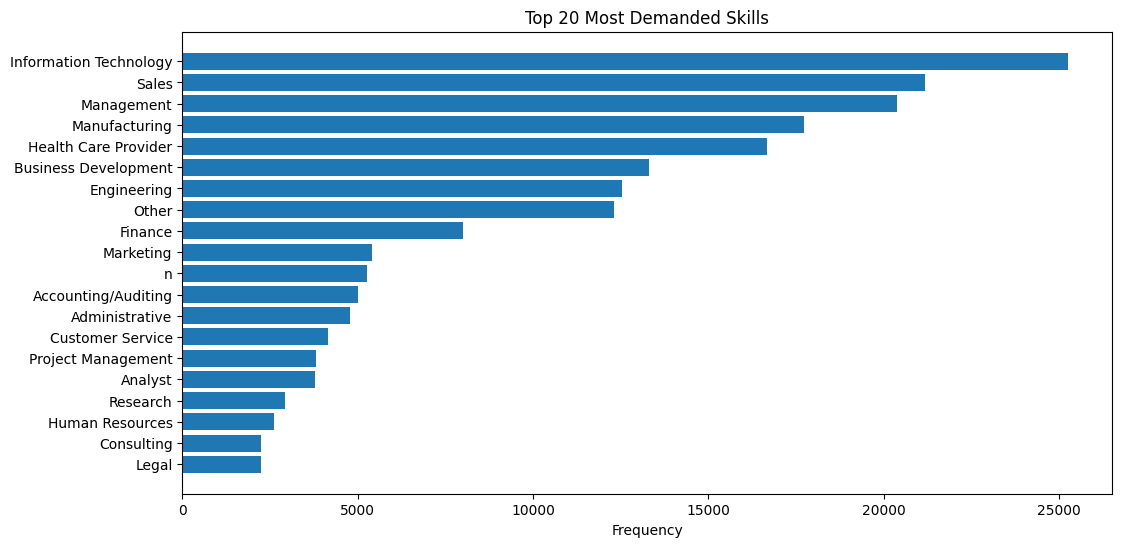

<Figure size 640x480 with 0 Axes>

In [27]:
# Flatten skills
all_skills = [
    skill 
    for sublist in jobs_clean['skill_list'].dropna()
    for skill in sublist
]

skill_counts = Counter(all_skills)
top20 = skill_counts.most_common(20)

skills, counts = zip(*top20)

plt.figure(figsize=(12, 6))
plt.barh(skills, counts)
plt.gca().invert_yaxis()    # Highest on top
plt.title("Top 20 Most Demanded Skills")
plt.xlabel("Frequency")
plt.show()
plt.savefig('figures/ACskills.png', dpi=300, bbox_inches='tight')


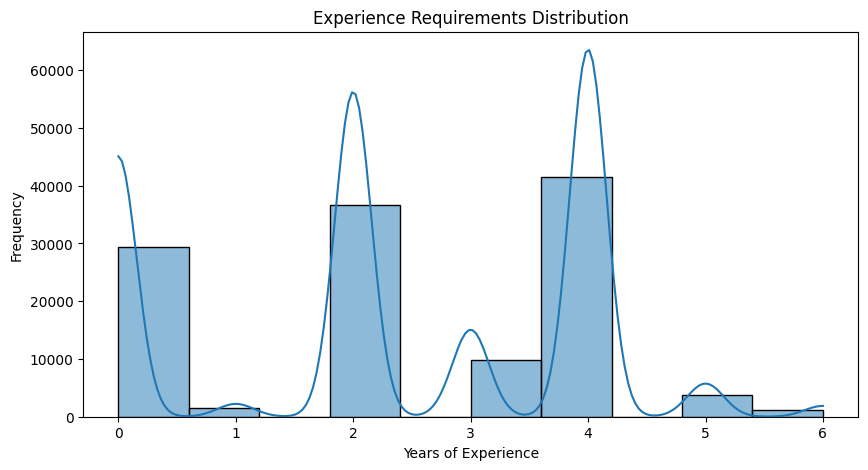

<Figure size 640x480 with 0 Axes>

In [28]:
plt.figure(figsize=(10,5))
sns.histplot(jobs_clean['experience_numeric'].dropna(), bins=10, kde=True)
plt.title("Experience Requirements Distribution")
plt.xlabel("Years of Experience")
plt.ylabel("Frequency")
plt.show()
plt.savefig('figures/ACexperience_requirements_distribution.png', dpi=300, bbox_inches='tight')

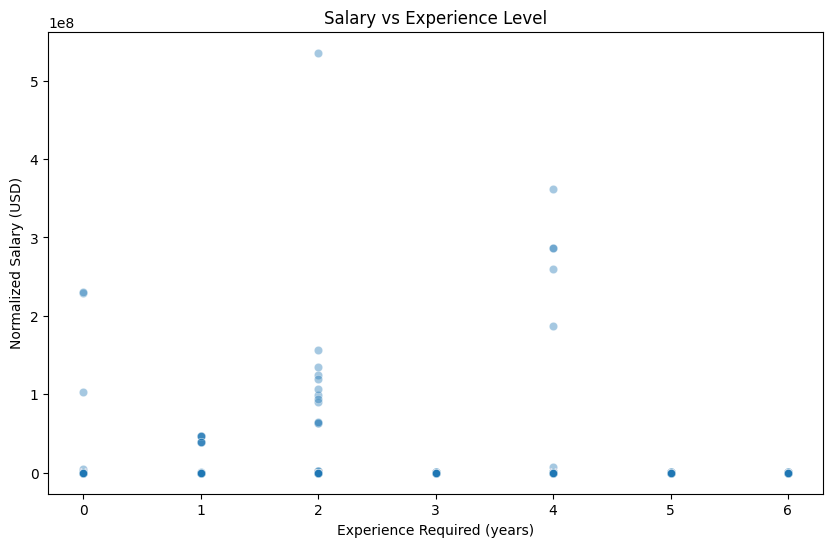

<Figure size 640x480 with 0 Axes>

In [29]:
salary_exp_df = jobs_clean.dropna(subset=['normalized_salary', 'experience_numeric'])

plt.figure(figsize=(10,6))
sns.scatterplot(
    x=salary_exp_df['experience_numeric'],
    y=salary_exp_df['normalized_salary'],
    alpha=0.4
)
plt.title("Salary vs Experience Level")
plt.xlabel("Experience Required (years)")
plt.ylabel("Normalized Salary (USD)")
plt.show()
plt.savefig('figures/ACsalary_vs_experience.png', dpi=300, bbox_inches='tight')


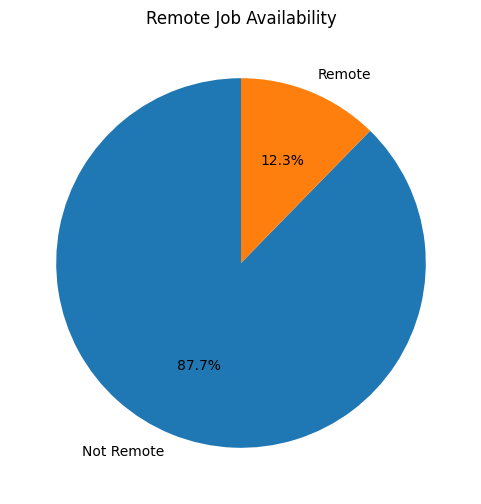

<Figure size 640x480 with 0 Axes>

In [30]:
# Convert remote_allowed to numeric (0 = No, 1 = Yes)
jobs_clean['remote_allowed'] = jobs_clean['remote_allowed'].astype(str).str.strip()
jobs_clean['remote_allowed'] = jobs_clean['remote_allowed'].replace({
    '0': 0, 'false': 0, 'False': 0,
    '1': 1, 'true': 1, 'True': 1
}).astype(float)

# Count each category
remote_counts = jobs_clean['remote_allowed'].value_counts(dropna=False)
labels = ['Not Remote', 'Remote']

plt.figure(figsize=(6,6))
plt.pie(remote_counts, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title("Remote Job Availability")
plt.show()
plt.savefig('figures/ACremote_job_availability.png', dpi=300, bbox_inches='tight')



Job Description Length:
   Mean: 3766 characters
   Median: 3435 characters
   Shortest: 2 characters
   Longest: 23201 characters
Saved plot: figures/ACdescription_length_dist.png


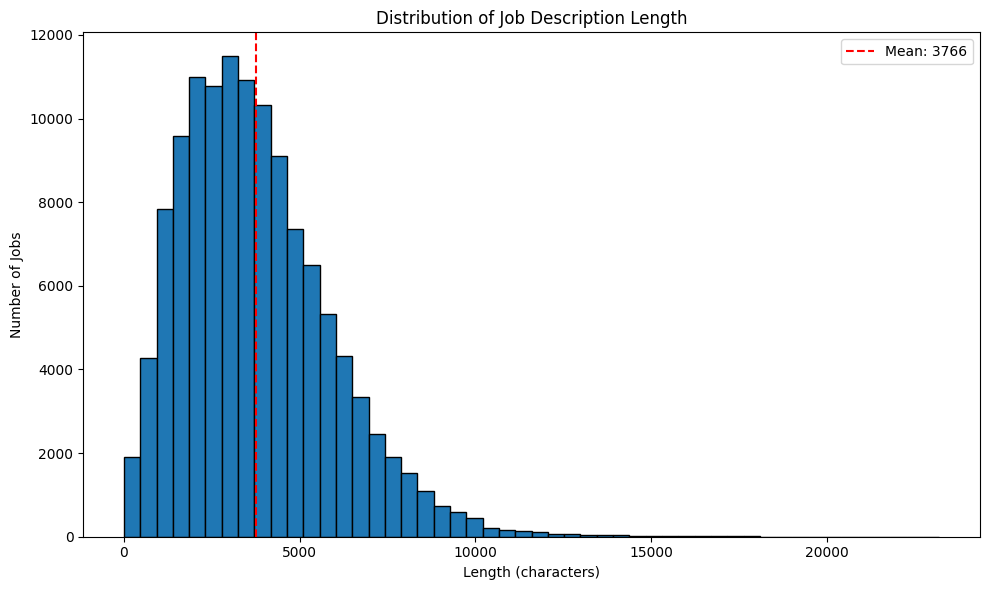

In [ ]:
#Description length
print("\nJob Description Length:")

if 'description' in jobs_clean.columns:
    #Calculate description lengths
    jobs_clean['description_length'] = jobs_clean['description'].fillna('').str.len()
    
    stats = jobs_clean['description_length'].describe()
    print(f"   Mean: {stats['mean']:.0f} characters")
    print(f"   Median: {stats['50%']:.0f} characters")
    print(f"   Shortest: {stats['min']:.0f} characters")
    print(f"   Longest: {stats['max']:.0f} characters")
    
    #Distribution plot
    plt.figure(figsize=(10, 6))
    plt.hist(jobs_clean['description_length'], bins=50, edgecolor='black')
    plt.xlabel('Length (characters)')
    plt.ylabel('Number of Jobs')
    plt.title('Distribution of Job Description Length')
    plt.axvline(stats['mean'], color='red', linestyle='--', label=f'Mean: {stats["mean"]:.0f}')
    plt.legend()
    plt.tight_layout()
    plt.savefig('figures/ACdescription_length_dist.png', dpi=300, bbox_inches='tight')



Type of Employment:
Work Types:
    1. Full-time: 98,814 types
    2. Contract: 12,117 types
    3. Part-time: 9,696 types
    4. Temporary: 1,190 types
    5. Internship: 983 types
    6. Volunteer: 562 types
    7. Other: 487 types
Saved plot: figures/ACwork_types.png


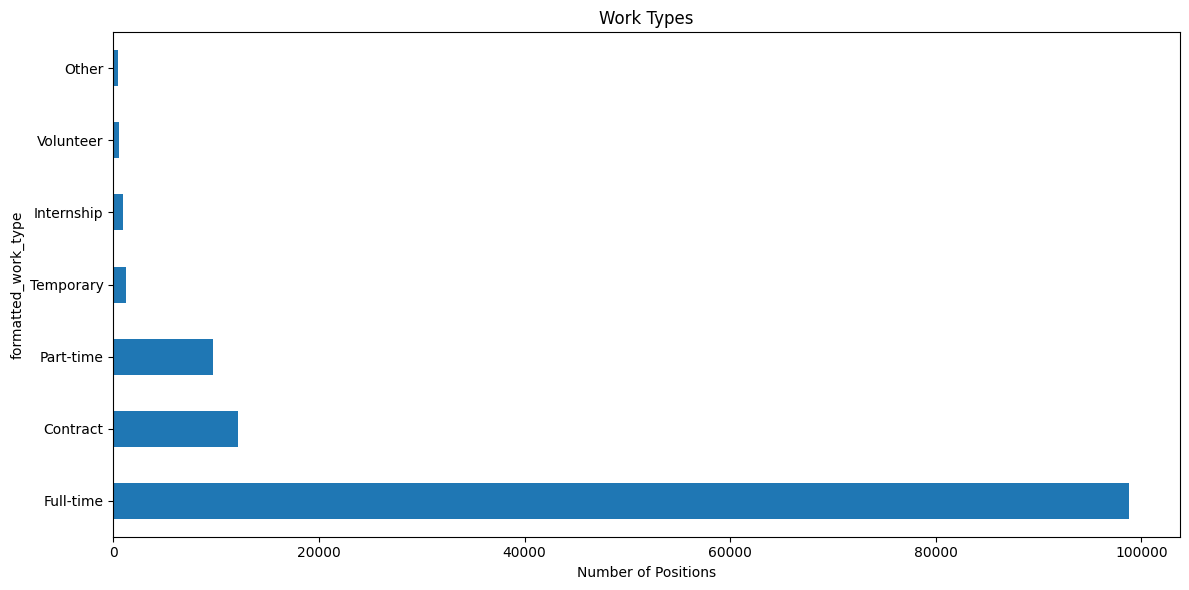

In [ ]:
#Type of employment
print("\nType of Employment:")

if 'formatted_work_type' in jobs_df.columns:
    #Work types count
    work_types = jobs_df['formatted_work_type'].value_counts().head(20)
    print(f"Work Types:")
    for i, (formatted_work_type, count) in enumerate(work_types.head(10).items(), 1):
        print(f"   {i:2d}. {formatted_work_type}: {count:,} types")
    
    #Plot
    plt.figure(figsize=(12, 6))
    work_types.head(15).plot(kind='barh')
    plt.xlabel('Number of Positions')
    plt.title('Work Types')
    plt.tight_layout()
    plt.savefig('figures/ACwork_types.png', dpi=300, bbox_inches='tight')



Experience Levels:
Experience Levels:
    1. mid senior: 41,489 positions
    2. entry: 36,708 positions
    3. nan: 29,402 positions
    4. associate: 9,826 positions
    5. director: 3,746 positions
    6. internship: 1,449 positions
    7. executive: 1,222 positions
Saved plot: figures/ACexperience_levels.png


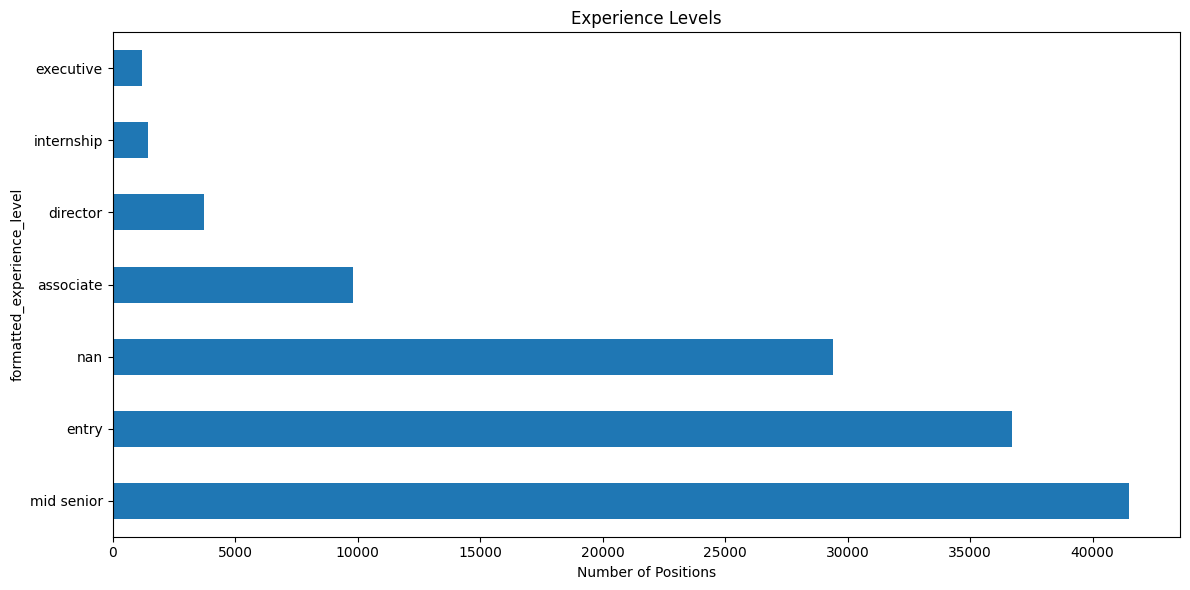

In [ ]:
#Type of experience level
print("\nExperience Levels:")

if 'formatted_experience_level' in jobs_clean.columns:
    #Work types count
    experience_levels = jobs_clean['formatted_experience_level'].value_counts().head(20)
    print(f"Experience Levels:")
    for i, (formatted_experience_level, count) in enumerate(experience_levels.head(10).items(), 1):
        print(f"   {i:2d}. {formatted_experience_level}: {count:,} positions")
    
    #Plot
    plt.figure(figsize=(12, 6))
    experience_levels.head(15).plot(kind='barh')
    plt.xlabel('Number of Positions')
    plt.title('Experience Levels')
    plt.tight_layout()
    plt.savefig('figures/ACexperience_levels.png', dpi=300, bbox_inches='tight')

In [31]:
jobs_clean.to_csv("jobs_data.csv", index=False)